In [1]:
!pip install xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.9/115.9 MB 15.8 MB/s  0:00:07m0:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.8/296.8 MB 15.4 MB/s  0:00:17m0:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [xgboost]m1/2 [xgboost]


In [21]:
!pip install shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 23.0 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [shap]1/2 [shap]


In [22]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
import seaborn as sns
import matplotlib.pyplot as plt
import shap
import pandas as pd

In [27]:
df = pd.read_csv("feat_engineered_normalized_dset.csv", index_col=0)
df.head()

,mean,std,min,q1,median,q3,max,iqr,skew,kurtosis,label
0,0.162237,0.148038,-0.132835,-0.370153,0.373207,0.103133,0.391489,0.333210,-0.372680,-0.277113,pulsar
1,0.153767,0.142553,-0.132835,-0.370153,0.363400,0.121570,0.391489,0.356461,-0.373431,-0.281692,pulsar
2,0.131413,0.120962,-0.132835,-0.370153,0.326621,0.067839,0.391489,0.288702,-0.309927,-0.222986,pulsar
3,0.122973,0.120328,-0.132835,-0.370153,0.308232,0.057304,0.391489,0.275416,-0.290519,-0.210699,pulsar
4,0.117429,0.107567,-0.132835,-0.370153,0.313136,0.009894,0.391489,0.215628,-0.294595,-0.218115,pulsar


In [28]:
mapping = dict(enumerate(df['label'].astype('category').cat.categories))
print(mapping)

{0: 'bh', 1: 'pulsar'}


In [29]:
X, y = df.drop(columns=["label"]), df["label"].astype('category').cat.codes

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y  # keeps class proportions consistent
)


In [30]:
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)


In [31]:
clf = XGBClassifier(
    n_estimators=400,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    eval_metric="logloss",
    tree_method="hist",   # fast GPU-like speed on CPU
)


In [32]:
clf.fit(X_train_res, y_train_res)

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'logloss'


In [33]:
y_pred = clf.predict(X_test)

In [34]:
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.96      0.97      0.96       666
           1       0.99      0.99      0.99      2230

    accuracy                           0.98      2896
   macro avg       0.97      0.98      0.98      2896
weighted avg       0.98      0.98      0.98      2896



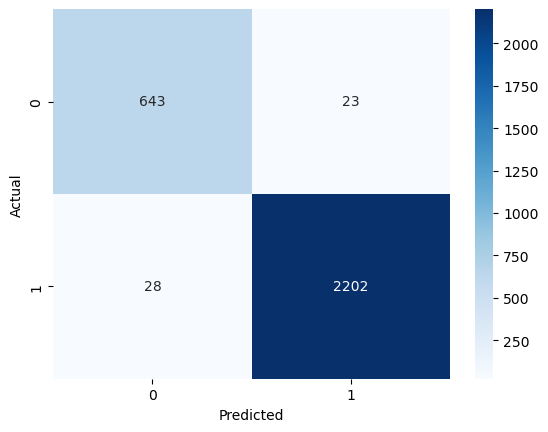

In [35]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [36]:
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X_test)
# If explainer returns a list (tree models sometimes do)
if isinstance(shap_values, list):
    shap_values = shap_values[1]  # use positive class


In [46]:
clf.classes_, mapping

(array([0, 1]), {0: 'bh', 1: 'pulsar'})

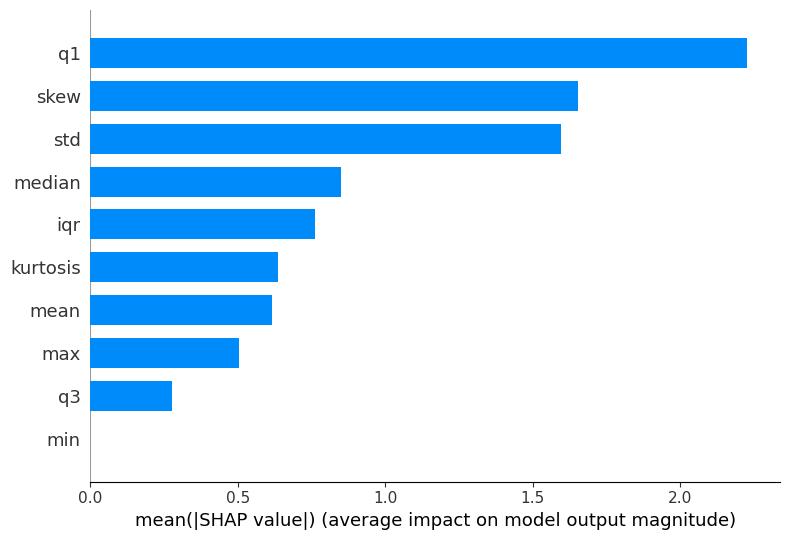

In [37]:
shap.summary_plot(shap_values, X_test, feature_names=X.columns, plot_type="bar")


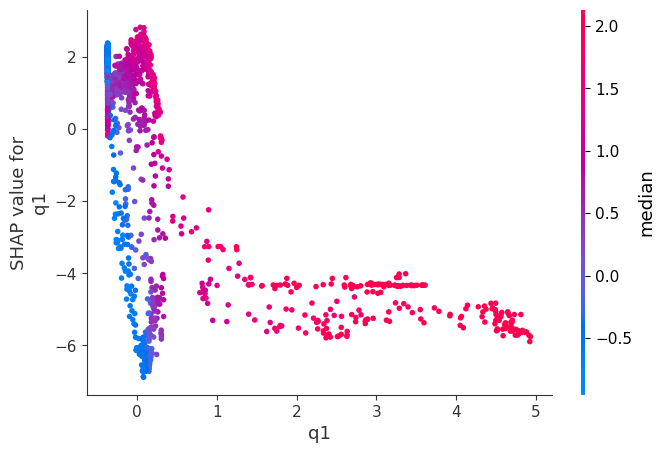

In [39]:
shap.dependence_plot("q1", shap_values, X_test)


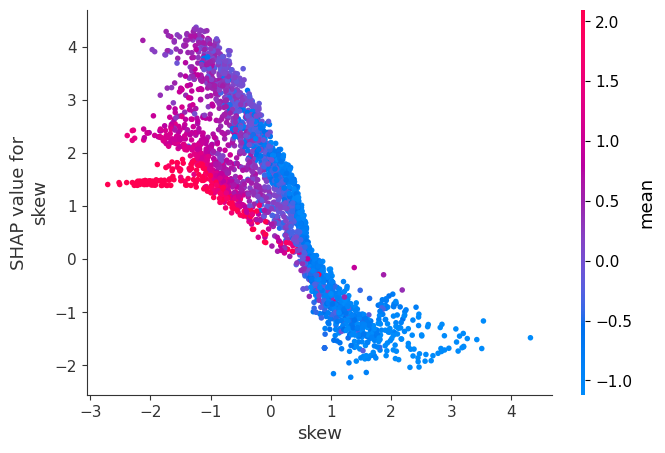

In [40]:
shap.dependence_plot("skew", shap_values, X_test)

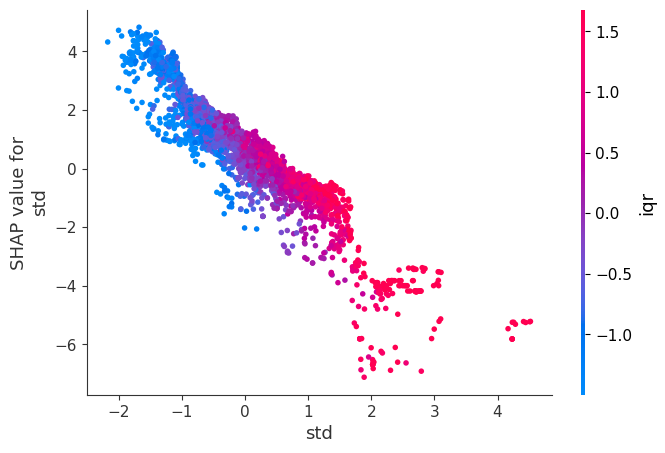

In [41]:
shap.dependence_plot("std", shap_values, X_test)

In [50]:
clf.save_model("xgboost_small.json")

In [51]:
# test on the large dataset from the small dataset

In [ ]:
filepath = "/home/idies/workspace/Storage/002375816/persistent/full_1800.h5"

In [52]:
def generate_engineered_dset(filepath, num_rows=None):
    if num_rows:
        # there are 2 datasets, X and y. Let's examine the X
        with h5py.File(filepath, "r") as f:
            X = f["phi"][:num_rows]
            print("shape:", X.shape)
        # there are 2 datasets, X and y. Let's examine the y
        with h5py.File(filepath, "r") as f:
            y = f["is_pulsar"][:num_rows]
            print("shape:", y.shape)
    else:
        # there are 2 datasets, X and y. Let's examine the X
        with h5py.File(filepath, "r") as f:
            X = f["phi"][:]
            print("shape:", X.shape)
        # there are 2 datasets, X and y. Let's examine the y
        with h5py.File(filepath, "r") as f:
            y = f["is_pulsar"][:]
    
    X_df = pd.DataFrame(X)
    y_df = pd.DataFrame(y)
    pulsars_df = X_df[(y_df == 1).values]
    bh_df = X_df[(y_df == 0).values]

    def row_summary_stats(df):
        num_df = df.select_dtypes(include='number')
        
        summary = pd.DataFrame({
            'mean':   num_df.mean(axis=1),
            'std':    num_df.std(axis=1),
            'min':    num_df.min(axis=1),
            'q1':     num_df.quantile(0.25, axis=1),
            'median': num_df.quantile(0.50, axis=1),
            'q3':     num_df.quantile(0.75, axis=1),
            'max':    num_df.max(axis=1),
            'iqr':    num_df.quantile(0.75, axis=1) - num_df.quantile(0.25, axis=1),
            'skew':   num_df.skew(axis=1),
            'kurtosis': num_df.kurtosis(axis=1)
        })
        
        return summary

    p_row_stats = row_summary_stats(pulsars_df)
    bh_row_stats = row_summary_stats(bh_df)
    p_row_stats["group"] = "pulsar"
    bh_row_stats["group"] = "bh"
    row_stats = pd.concat([p_row_stats, bh_row_stats], axis=0).reset_index(drop=True)

    return row_stats
    

In [ ]:
generate_engineered_dset(filepath, 500)